### 1. Import Packages and load the Data

In [360]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy import stats
from xgboost import XGBClassifier

## Loadning the data

In [361]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
sample_submission_df = pd.read_csv("sample_submission.csv")

### 2. Data Prepration

In [362]:
# Drop 'id' column (not useful for model training)
train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [363]:
print ('Columns: ')
print (train_df.columns.values)
print ('-'*70)
print ('shape: ', train_df.shape)
print("____"*20)
print ('Columns: ')
print (test_df.columns.values)
print ('-'*70)
print ('shape: ', test_df.shape)

Columns: 
['N_Days' 'Drug' 'Age' 'Sex' 'Ascites' 'Hepatomegaly' 'Spiders' 'Edema'
 'Bilirubin' 'Cholesterol' 'Albumin' 'Copper' 'Alk_Phos' 'SGOT'
 'Tryglicerides' 'Platelets' 'Prothrombin' 'Stage' 'Status']
----------------------------------------------------------------------
shape:  (15000, 19)
________________________________________________________________________________
Columns: 
['N_Days' 'Drug' 'Age' 'Sex' 'Ascites' 'Hepatomegaly' 'Spiders' 'Edema'
 'Bilirubin' 'Cholesterol' 'Albumin' 'Copper' 'Alk_Phos' 'SGOT'
 'Tryglicerides' 'Platelets' 'Prothrombin' 'Stage']
----------------------------------------------------------------------
shape:  (10000, 18)


In [364]:
print (train_df.info())
print ('*'*20)
print (test_df.info())
print ('*'*20)
print(sample_submission_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         15000 non-null  float64
 1   Drug           8492 non-null   object 
 2   Age            15000 non-null  float64
 3   Sex            15000 non-null  object 
 4   Ascites        8494 non-null   object 
 5   Hepatomegaly   8487 non-null   object 
 6   Spiders        8485 non-null   object 
 7   Edema          15000 non-null  object 
 8   Bilirubin      15000 non-null  float64
 9   Cholesterol    6612 non-null   float64
 10  Albumin        15000 non-null  float64
 11  Copper         8364 non-null   float64
 12  Alk_Phos       8485 non-null   float64
 13  SGOT           8480 non-null   float64
 14  Tryglicerides  6560 non-null   float64
 15  Platelets      14429 non-null  float64
 16  Prothrombin    14979 non-null  float64
 17  Stage          15000 non-null  float64
 18  Status

In [365]:
#Categorical Features
# This will show the count, number of unique values, top values and most frquency of categorical columns.
train_df.describe(include=['O'])

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Status
count,8492,15000,8494,8487,8485,15000,15000
unique,2,2,3,3,2,3,3
top,D-penicillamine,F,N,N,N,N,C
freq,4493,14380,8088,4533,6706,13838,10103


In [366]:
# Check for missing values
print(train_df.isna().sum().sort_values())
print("___"*20)
print(test_df.isna().sum().sort_values())

N_Days              0
Albumin             0
Stage               0
Bilirubin           0
Edema               0
Status              0
Sex                 0
Age                 0
Prothrombin        21
Platelets         571
Ascites          6506
Drug             6508
Hepatomegaly     6513
Spiders          6515
Alk_Phos         6515
SGOT             6520
Copper           6636
Cholesterol      8388
Tryglicerides    8440
dtype: int64
____________________________________________________________
N_Days              0
Albumin             0
Edema               0
Bilirubin           0
Age                 0
Sex                 0
Stage               0
Prothrombin        15
Platelets         362
Ascites          4363
Drug             4369
Alk_Phos         4372
Hepatomegaly     4374
SGOT             4374
Spiders          4375
Copper           4446
Cholesterol      5605
Tryglicerides    5640
dtype: int64


#### Columns which contains missing values


1_ Drug


2_ Ascites


3_ Hepatomegaly



4_ Spiders


5_ Cholesterol


6_ Copper


7_ Alk_Phos


8_ SGOT


9_ Tryglicerides


10_ Platelets


11_ Prothrombin

In [367]:
# Print the sample submission data to know it.
sample_submission_df.head().style.set_properties(**{"background-color": "pink","color":"black","border": "1.5px solid Yellow"})

,id,Status_C,Status_CL,Status_D
0,15000,0.628084,0.034788,0.337128
1,15001,0.628084,0.034788,0.337128
2,15002,0.628084,0.034788,0.337128
3,15003,0.628084,0.034788,0.337128
4,15004,0.628084,0.034788,0.337128


## Data Prepration:
####       1. Handle Missing Vlues
####        2. encode categories
####        3. normalize the data

In [368]:
# This function is going to check the data types for columns, unique values and missing values.

def check(df):
    check_list=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        check_list.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(check_list)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 
print(check(train_df))
print("____"*20)
print(check(test_df))

           column   dtypes  nunique  sum_null
0          N_Days  float64      548         0
1            Drug   object        2      6508
2             Age  float64      394         0
3             Sex   object        2         0
4         Ascites   object        3      6506
5    Hepatomegaly   object        3      6513
6         Spiders   object        2      6515
7           Edema   object        3         0
8       Bilirubin  float64      116         0
9     Cholesterol  float64      217      8388
10        Albumin  float64      163         0
11         Copper  float64      174      6636
12       Alk_Phos  float64      392      6515
13           SGOT  float64      202      6520
14  Tryglicerides  float64      149      8440
15      Platelets  float64      260       571
16    Prothrombin  float64       53        21
17          Stage  float64        4         0
18         Status   object        3         0
________________________________________________________________________________

In [369]:
# Drop duplicates
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

In [370]:
# Check the shape of data.
print(f"The shape of train data: {train_df.shape}")
print("___"*20)
print(f"The shape of test data: {test_df.shape}")

The shape of train data: (14995, 19)
____________________________________________________________
The shape of test data: (10000, 18)


## Handle missing Values

In [371]:
print(train_df.isna().sum().sort_values())
print("___"*20)
print(test_df.isna().sum().sort_values())

N_Days              0
Albumin             0
Stage               0
Bilirubin           0
Edema               0
Status              0
Sex                 0
Age                 0
Prothrombin        21
Platelets         571
Ascites          6501
Drug             6503
Hepatomegaly     6508
Spiders          6510
Alk_Phos         6510
SGOT             6515
Copper           6631
Cholesterol      8383
Tryglicerides    8435
dtype: int64
____________________________________________________________
N_Days              0
Albumin             0
Edema               0
Bilirubin           0
Age                 0
Sex                 0
Stage               0
Prothrombin        15
Platelets         362
Ascites          4363
Drug             4369
Alk_Phos         4372
Hepatomegaly     4374
SGOT             4374
Spiders          4375
Copper           4446
Cholesterol      5605
Tryglicerides    5640
dtype: int64


In [372]:
# Split numeric and categorical columns
train_numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns
train_categorical_columns = train_df.select_dtypes(include=['object']).columns

test_numeric_columns = test_df.select_dtypes(include=['float64', 'int64']).columns
test_categorical_columns = test_df.select_dtypes(include=['object']).columns

In [373]:
print(train_numeric_columns)
print("___"*20)
print(test_numeric_columns)

Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')
____________________________________________________________
Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')


This dataset contains 13 numerical columns

In [374]:
print(train_categorical_columns)
print("___"*20)
print(test_categorical_columns)

Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status'], dtype='object')
____________________________________________________________
Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')


The dataset contains 7 categorical columns

In [375]:
# Function to convert days to years
def convert_days_to_years(days):
    return round(days / 365.25, 0)  # Convert and round to 2 decimal places

# Apply the function to the Age column
train_df['Age'] = train_df['Age'].apply(convert_days_to_years)
test_df['Age'] = test_df['Age'].apply(convert_days_to_years)

#### Fill missing values

In [376]:
# For categorical columns in train_df,  I create an imputer
imputer_train_cat = SimpleImputer(strategy='constant', fill_value='Unknown')
train_df[train_categorical_columns] = imputer_train_cat.fit_transform(train_df[train_categorical_columns])

# For categorical columns in test_df,  I create another imputer
imputer_test_cat = SimpleImputer(strategy='constant', fill_value='Unknown')
test_df[test_categorical_columns] = imputer_test_cat.fit_transform(test_df[test_categorical_columns])

# Create an imputer for numerical columns on train_df
imputer_train_num = SimpleImputer(strategy='median')
train_df[train_numeric_columns] = imputer_train_num.fit_transform(train_df[train_numeric_columns])

# Create an imputer for numerical columns on test_df
imputer_test_num = SimpleImputer(strategy='median')
test_df[test_numeric_columns] = imputer_test_num.fit_transform(test_df[test_numeric_columns])

In [377]:
print(train_df.tail())
print("____"*20)
print(test_df.tail())

       N_Days             Drug   Age Sex  Ascites Hepatomegaly  Spiders Edema  \
14995   837.0          Placebo  36.0   F        N            N        N     N   
14996  2563.0          Unknown  65.0   F  Unknown      Unknown  Unknown     N   
14997  1223.0  D-penicillamine  44.0   F        N            N        N     N   
14998   797.0  D-penicillamine  61.0   M        N            N        N     N   
14999   321.0  D-penicillamine  47.0   M        Y            Y        N     Y   

       Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
14995        2.1        342.0     3.61    52.0    1268.0   60.45   
14996        2.7        280.0     3.23    52.0    1072.0   97.65   
14997        0.6        280.0     3.34    31.0     663.0   74.40   
14998        5.9        364.0     3.38   161.0    1440.0  134.85   
14999        1.8        460.0     2.80   108.0    1472.0   71.30   

       Tryglicerides  Platelets  Prothrombin  Stage Status  
14995          213.0      268.0         10.

In [378]:
print(train_df["Cholesterol"].describe())
print("____"*20)
print(test_df["Cholesterol"].describe())

count    14995.000000
mean       299.757399
std        116.413584
min         17.200000
25%        280.000000
50%        280.000000
75%        280.000000
max       2880.000000
Name: Cholesterol, dtype: float64
________________________________________________________________________________
count    10000.000000
mean       298.885300
std        121.734341
min        105.000000
25%        277.000000
50%        277.000000
75%        277.000000
max       1775.000000
Name: Cholesterol, dtype: float64


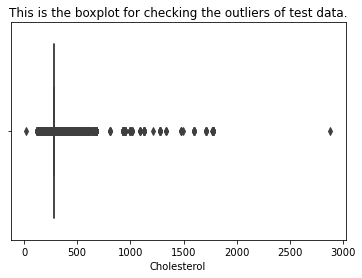

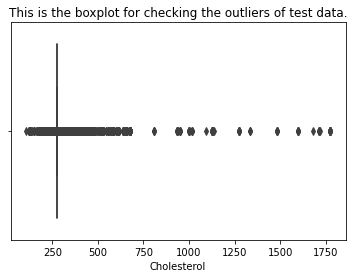

In [379]:
sns.boxplot( x= train_df["Cholesterol"])
plt.title("This is the boxplot for checking the outliers of test data.")
plt.show()

sns.boxplot( x= test_df["Cholesterol"])
plt.title("This is the boxplot for checking the outliers of test data.")
plt.show()

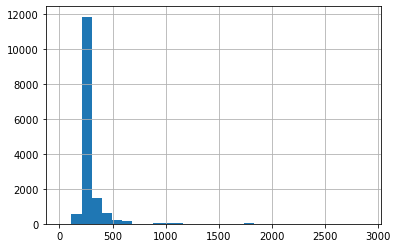

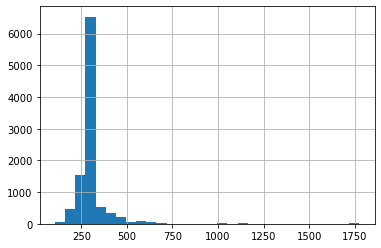

In [380]:
train_df["Cholesterol"].hist(bins=30)
plt.show()

test_df["Cholesterol"].hist(bins=30)
plt.show()

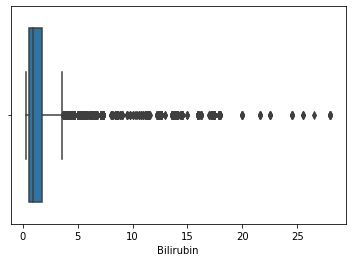

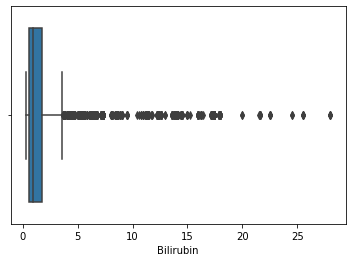

In [381]:
sns.boxplot(train_df["Bilirubin"])
plt.show()

sns.boxplot(test_df["Bilirubin"])
plt.show()

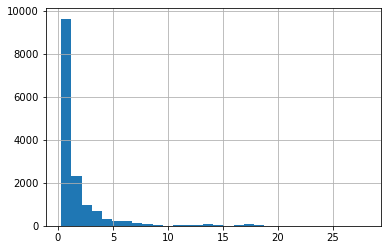

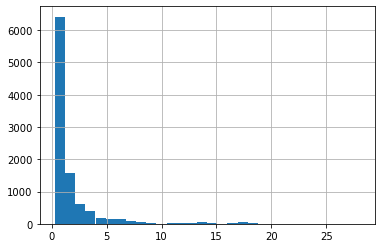

In [382]:
train_df["Bilirubin"].hist(bins=30)
plt.show()

test_df["Bilirubin"].hist(bins=30)
plt.show()

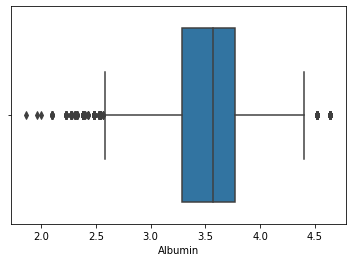

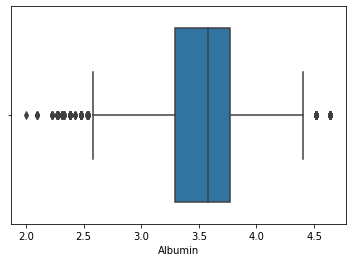

In [383]:
sns.boxplot(train_df["Albumin"])
plt.show()

sns.boxplot(test_df["Albumin"])
plt.show()

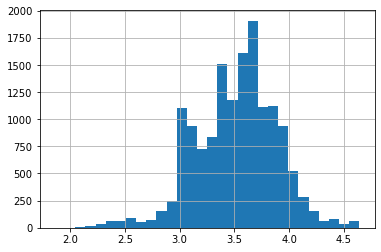

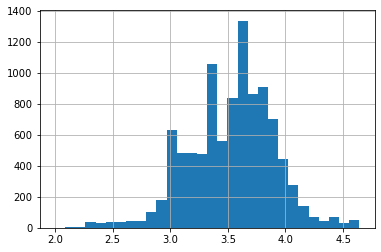

In [384]:
train_df["Albumin"].hist(bins=30)
plt.show()

test_df["Albumin"].hist(bins=30)
plt.show()

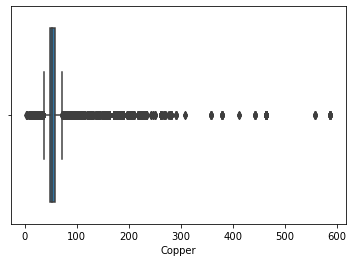

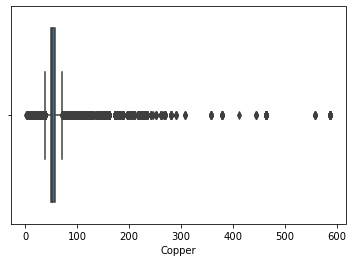

In [385]:
sns.boxplot(train_df["Copper"])
plt.show()

sns.boxplot(test_df["Copper"])
plt.show()

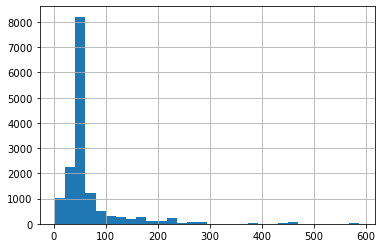

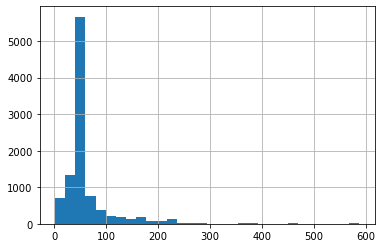

In [386]:
train_df["Copper"].hist(bins=30)
plt.show()

test_df["Copper"].hist(bins=30)
plt.show()

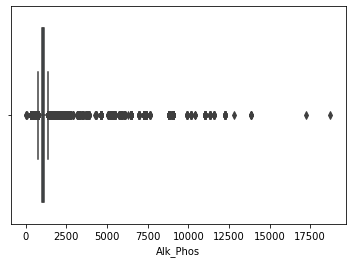

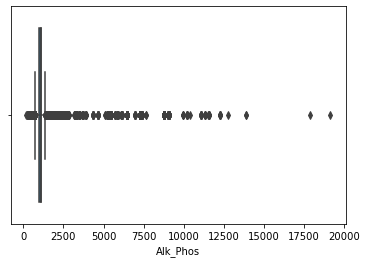

In [387]:
sns.boxplot(train_df["Alk_Phos"])
plt.show()

sns.boxplot(test_df["Alk_Phos"])
plt.show()

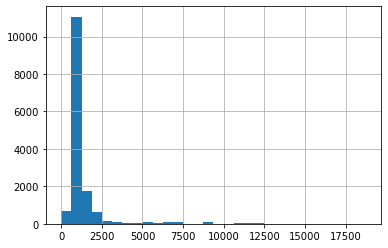

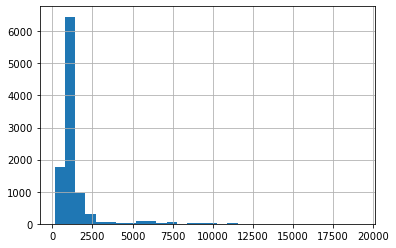

In [388]:
train_df["Alk_Phos"].hist(bins=30)
plt.show()

test_df["Alk_Phos"].hist(bins=30)
plt.show()

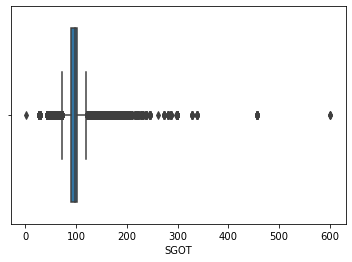

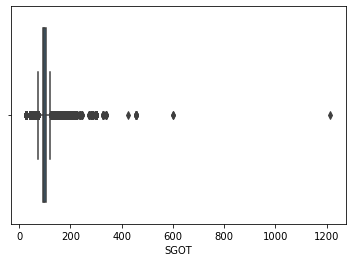

In [389]:
sns.boxplot(train_df["SGOT"])
plt.show()

sns.boxplot(test_df["SGOT"])
plt.show()

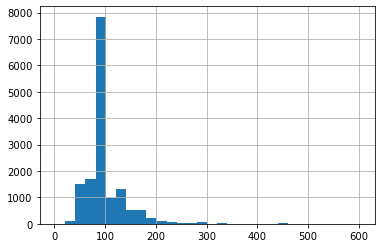

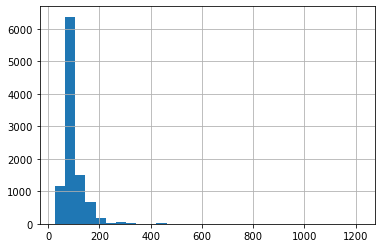

In [390]:
train_df["SGOT"].hist(bins=30)
plt.show()

test_df["SGOT"].hist(bins=30)
plt.show()

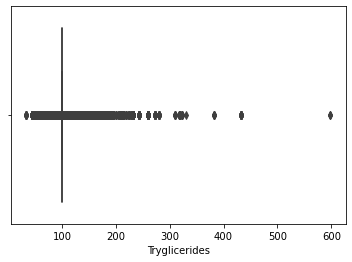

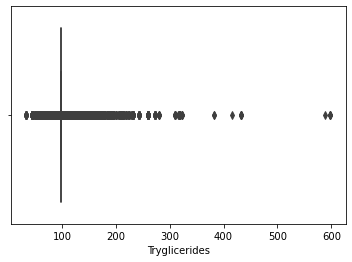

In [391]:
sns.boxplot(train_df["Tryglicerides"])
plt.show()

sns.boxplot(test_df["Tryglicerides"])
plt.show()

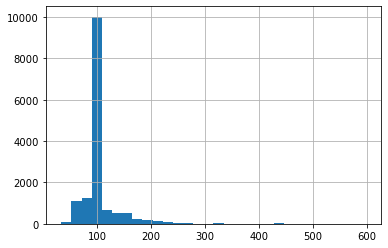

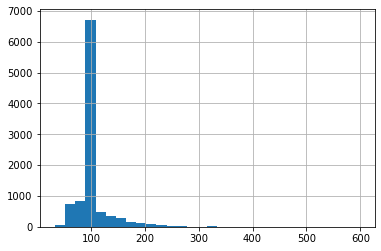

In [392]:
train_df["Tryglicerides"].hist(bins=30)
plt.show()

test_df["Tryglicerides"].hist(bins=30)
plt.show()

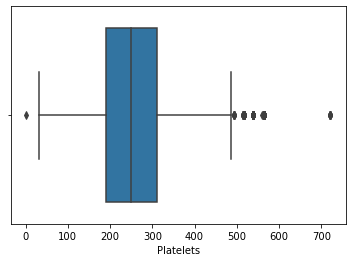

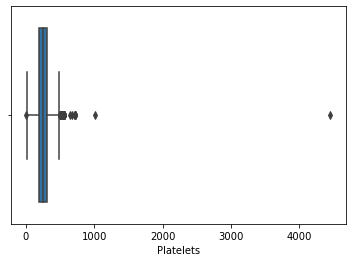

In [393]:
sns.boxplot(train_df["Platelets"])
plt.show()

sns.boxplot(test_df["Platelets"])
plt.show()

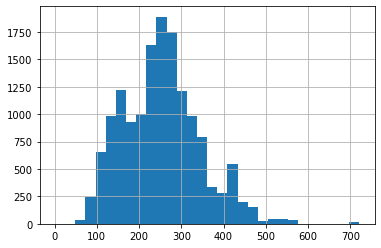

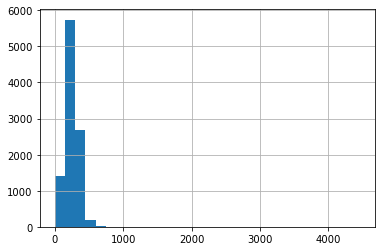

In [394]:
train_df["Platelets"].hist(bins=30)
plt.show()

test_df["Platelets"].hist(bins=30)
plt.show()

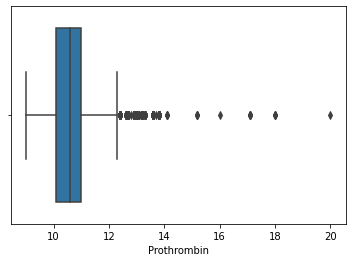

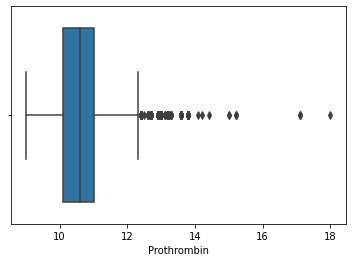

In [395]:
sns.boxplot(train_df["Prothrombin"])
plt.show()

sns.boxplot(test_df["Prothrombin"])
plt.show()

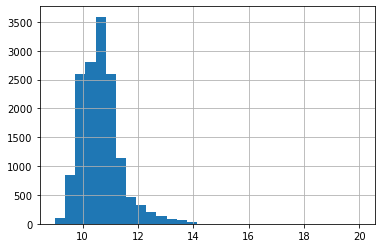

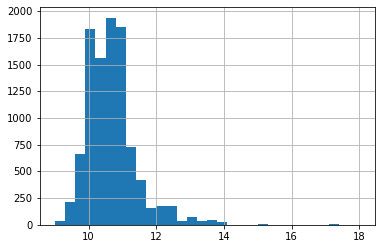

In [396]:
train_df["Prothrombin"].hist(bins=30)
plt.show()

test_df["Prothrombin"].hist(bins=30)
plt.show()

In [397]:
# Create a function to apply log transformation
def log_transform(df, column):
    # Add a small constant to avoid log(0)
    df[column] = np.log1p(df[column])  # log1p is log(1 + x)
    return df

# Apply log transformation to the numeric columns in the training DataFrame
for column in train_numeric_columns:
    train_df = log_transform(train_df, column)
    

# Apply log transformation to the numeric columns in the testing DataFrame
for column in test_numeric_columns:
    test_df = log_transform(test_df, column)

In [398]:
print(train_df["Cholesterol"].describe())
print("___"*20)
print(test_df["Cholesterol"].describe())

count    14995.000000
mean         5.669417
std          0.239925
min          2.901422
25%          5.638355
50%          5.638355
75%          5.638355
max          7.965893
Name: Cholesterol, dtype: float64
____________________________________________________________
count    10000.000000
mean         5.664205
std          0.244249
min          4.663439
25%          5.627621
50%          5.627621
75%          5.627621
max          7.482119
Name: Cholesterol, dtype: float64


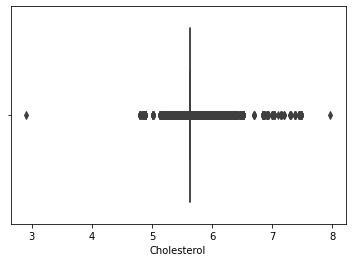

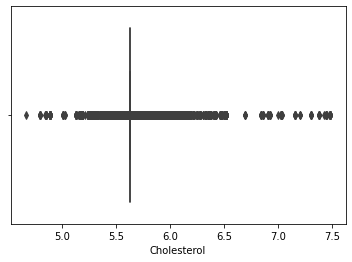

In [399]:
sns.boxplot(x = train_df["Cholesterol"])
plt.show()

sns.boxplot(x = test_df["Cholesterol"])
plt.show()

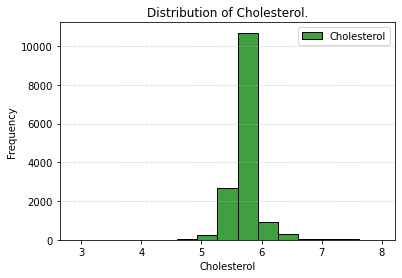

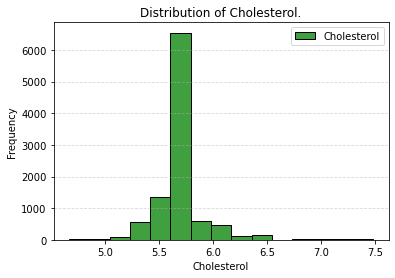

In [400]:
sns.histplot(train_df["Cholesterol"], color="green", label="Cholesterol")
plt.title('Distribution of Cholesterol.')
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

sns.histplot(test_df["Cholesterol"], color="green", label="Cholesterol")
plt.title('Distribution of Cholesterol.')
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [401]:
print(train_df["Bilirubin"].describe())
print("___"*20)
print(test_df["Bilirubin"].describe())

count    14995.000000
mean         0.857009
std          0.531864
min          0.262364
25%          0.470004
50%          0.641854
75%          1.029619
max          3.367296
Name: Bilirubin, dtype: float64
____________________________________________________________
count    10000.000000
mean         0.856654
std          0.535462
min          0.262364
25%          0.470004
50%          0.641854
75%          1.029619
max          3.367296
Name: Bilirubin, dtype: float64


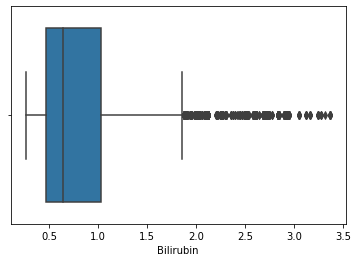

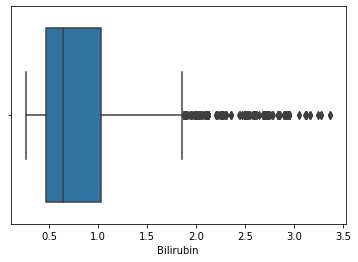

In [402]:
sns.boxplot(train_df["Bilirubin"])
plt.show()

sns.boxplot(test_df["Bilirubin"])
plt.show()

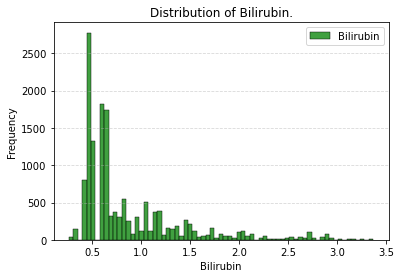

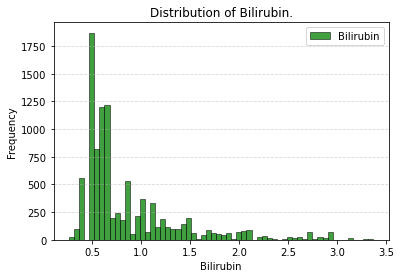

In [403]:
sns.histplot(train_df["Bilirubin"], color="green", label="Bilirubin")
plt.title('Distribution of Bilirubin.')
plt.xlabel('Bilirubin')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

sns.histplot(test_df["Bilirubin"], color="green", label="Bilirubin")
plt.title('Distribution of Bilirubin.')
plt.xlabel('Bilirubin')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [404]:
print(train_df["Albumin"].describe())
print("___"*20)
print(test_df["Albumin"].describe())

count    14995.000000
mean         1.504406
std          0.084523
min          1.050822
25%          1.456287
50%          1.519513
75%          1.562346
max          1.729884
Name: Albumin, dtype: float64
____________________________________________________________
count    10000.000000
mean         1.506526
std          0.084032
min          1.098612
25%          1.456287
50%          1.521699
75%          1.562346
max          1.729884
Name: Albumin, dtype: float64


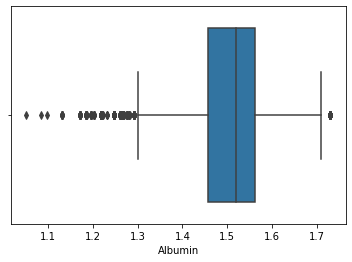

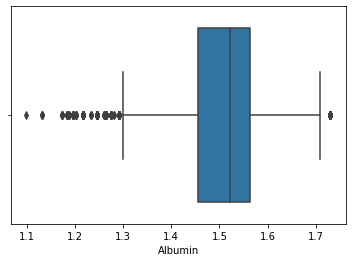

In [405]:
sns.boxplot(train_df["Albumin"])
plt.show()

sns.boxplot(test_df["Albumin"])
plt.show()

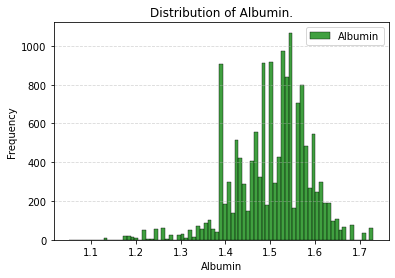

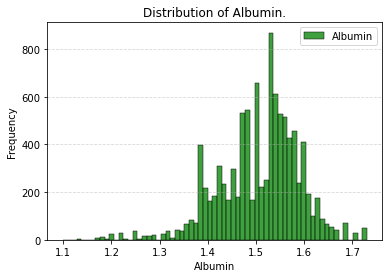

In [406]:
sns.histplot(train_df["Albumin"], color="green", label="Albumin")
plt.title('Distribution of Albumin.')
plt.xlabel('Albumin')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

sns.histplot(test_df["Albumin"], color="green", label="Albumin")
plt.title('Distribution of Albumin.')
plt.xlabel('Albumin')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [407]:
print(train_df["Copper"].describe())
print("___"*20)
print(test_df["Copper"].describe())

count    14995.000000
mean         3.995340
std          0.589202
min          1.098612
25%          3.912023
50%          3.970292
75%          4.077537
max          6.378426
Name: Copper, dtype: float64
____________________________________________________________
count    10000.000000
mean         3.993460
std          0.587362
min          0.693147
25%          3.931826
50%          3.970292
75%          4.077537
max          6.378426
Name: Copper, dtype: float64


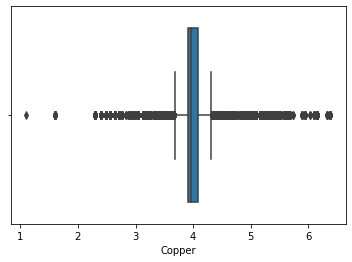

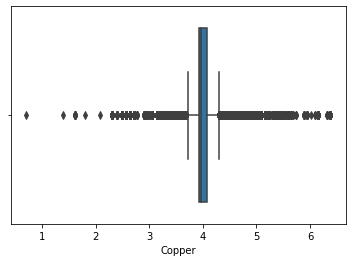

In [408]:
sns.boxplot(train_df["Copper"])
plt.show()

sns.boxplot(test_df["Copper"])
plt.show()

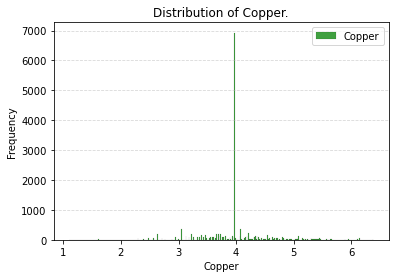

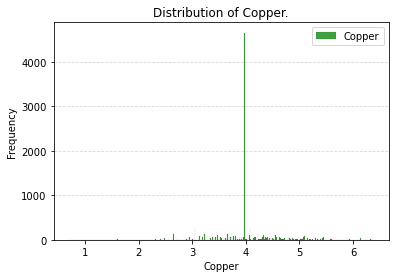

In [409]:
sns.histplot(train_df["Copper"], color="green", label="Copper")
plt.title('Distribution of Copper.')
plt.xlabel('Copper')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

sns.histplot(test_df["Copper"], color="green", label="Copper")
plt.title('Distribution of Copper.')
plt.xlabel('Copper')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [410]:
print(train_df["Alk_Phos"].describe())
print("___"*20)
print(test_df["Alk_Phos"].describe())

count    14995.000000
mean         7.042329
std          0.516999
min          1.327075
25%          6.883463
50%          6.978214
75%          7.034388
max          9.838095
Name: Alk_Phos, dtype: float64
____________________________________________________________
count    10000.000000
mean         7.035635
std          0.503263
min          5.075174
25%          6.884487
50%          6.974011
75%          7.029088
max          9.858584
Name: Alk_Phos, dtype: float64


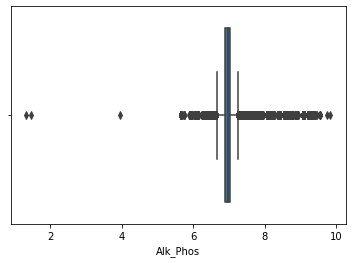

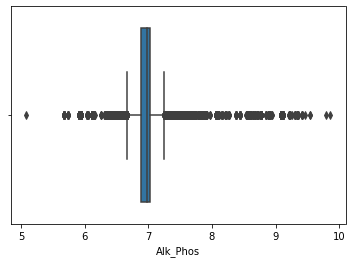

In [411]:
sns.boxplot(train_df["Alk_Phos"])
plt.show()

sns.boxplot(test_df["Alk_Phos"])
plt.show()

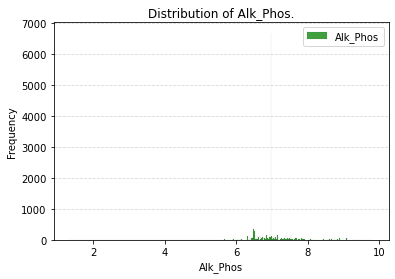

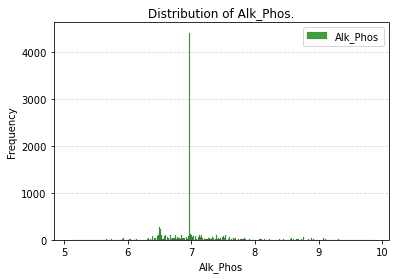

In [412]:
sns.histplot(train_df["Alk_Phos"], color="green", label="Alk_Phos")
plt.title('Distribution of Alk_Phos.')
plt.xlabel('Alk_Phos')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

sns.histplot(test_df["Alk_Phos"], color="green", label="Alk_Phos")
plt.title('Distribution of Alk_Phos.')
plt.xlabel('Alk_Phos')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [413]:
print(train_df["SGOT"].describe())
print("___"*20)
print(test_df["SGOT"].describe())

count    14995.000000
mean         4.585334
std          0.329385
min          0.641854
25%          4.509760
50%          4.591578
75%          4.637637
max          6.400839
Name: SGOT, dtype: float64
____________________________________________________________
count    10000.000000
mean         4.588639
std          0.322601
min          3.308717
25%          4.526668
50%          4.591578
75%          4.652531
max          7.102499
Name: SGOT, dtype: float64


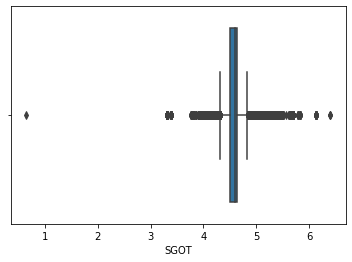

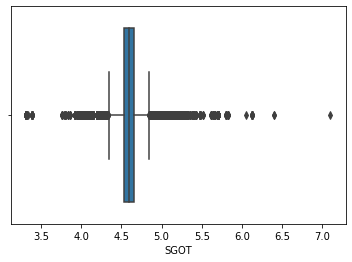

In [414]:
sns.boxplot(train_df["SGOT"])
plt.show()

sns.boxplot(test_df["SGOT"])
plt.show()

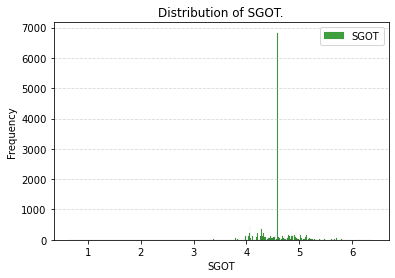

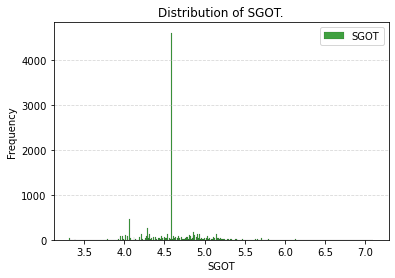

In [415]:
sns.histplot(train_df["SGOT"], color="green", label="SGOT")
plt.title('Distribution of SGOT.')
plt.xlabel('SGOT')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

sns.histplot(test_df["SGOT"], color="green", label="SGOT")
plt.title('Distribution of SGOT.')
plt.xlabel('SGOT')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [416]:
print(train_df["Tryglicerides"].describe())
print("___"*20)
print(test_df["Tryglicerides"].describe())

count    14995.000000
mean         4.628034
std          0.258966
min          3.526361
25%          4.615121
50%          4.615121
75%          4.615121
max          6.395262
Name: Tryglicerides, dtype: float64
____________________________________________________________
count    10000.000000
mean         4.618727
std          0.258719
min          3.526361
25%          4.605170
50%          4.605170
75%          4.605170
max          6.395262
Name: Tryglicerides, dtype: float64


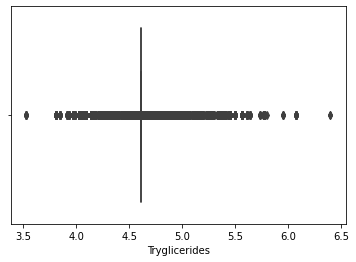

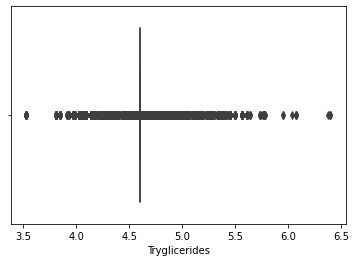

In [417]:
sns.boxplot(train_df["Tryglicerides"])
plt.show()

sns.boxplot(test_df["Tryglicerides"])
plt.show()

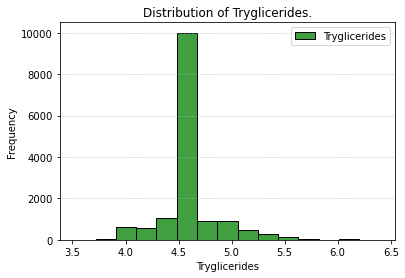

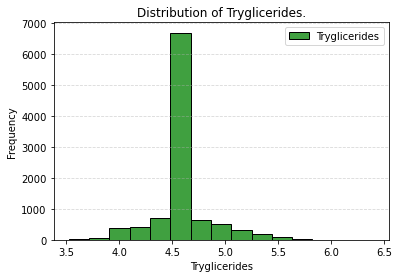

In [418]:
sns.histplot(train_df["Tryglicerides"], color="green", label="Tryglicerides")
plt.title('Distribution of Tryglicerides.')
plt.xlabel('Tryglicerides')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

sns.histplot(test_df["Tryglicerides"], color="green", label="Tryglicerides")
plt.title('Distribution of Tryglicerides.')
plt.xlabel('Tryglicerides')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [419]:
print(train_df["Platelets"].describe())
print("___"*20)
print(test_df["Platelets"].describe())

count    14995.000000
mean         5.470455
std          0.383868
min          0.641854
25%          5.252273
50%          5.521461
75%          5.743003
max          6.582025
Name: Platelets, dtype: float64
____________________________________________________________
count    10000.000000
mean         5.467292
std          0.384283
min          0.530628
25%          5.252273
50%          5.517453
75%          5.743003
max          8.401558
Name: Platelets, dtype: float64


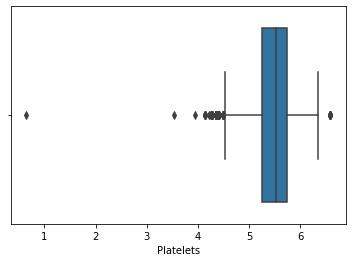

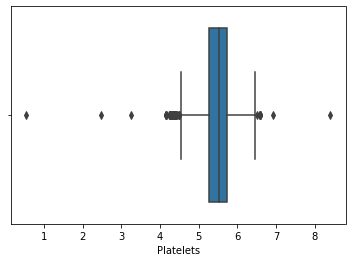

In [420]:
sns.boxplot(train_df["Platelets"])
plt.show()

sns.boxplot(test_df["Platelets"])
plt.show()

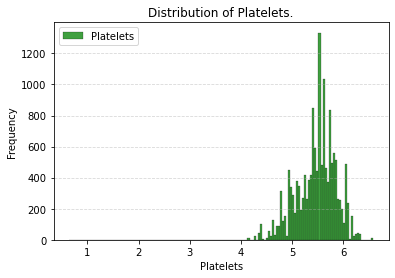

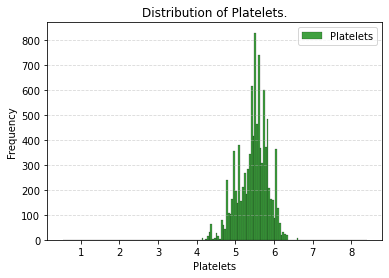

In [421]:
sns.histplot(train_df["Platelets"], color="green", label="Platelets")
plt.title('Distribution of Platelets.')
plt.xlabel('Platelets')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

sns.histplot(test_df["Platelets"], color="green", label="Platelets")
plt.title('Distribution of Platelets.')
plt.xlabel('Platelets')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [422]:
print(train_df["Prothrombin"].describe())
print("___"*20)
print(test_df["Prothrombin"].describe())

count    14995.000000
mean         2.452223
std          0.061479
min          2.302585
25%          2.406945
50%          2.451005
75%          2.484907
max          3.044522
Name: Prothrombin, dtype: float64
____________________________________________________________
count    10000.000000
mean         2.451550
std          0.061424
min          2.302585
25%          2.406945
50%          2.451005
75%          2.484907
max          2.944439
Name: Prothrombin, dtype: float64


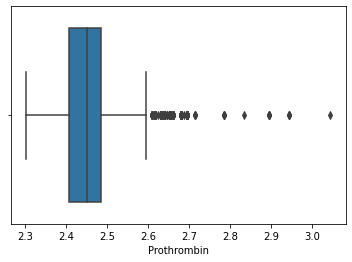

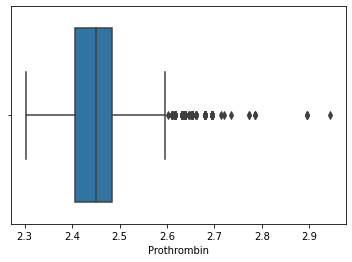

In [423]:
sns.boxplot(train_df["Prothrombin"])
plt.show()

sns.boxplot(test_df["Prothrombin"])
plt.show()

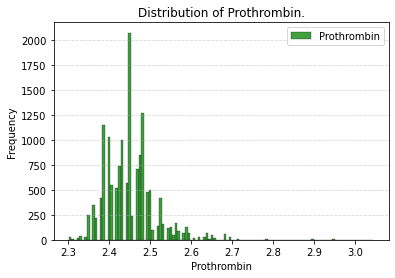

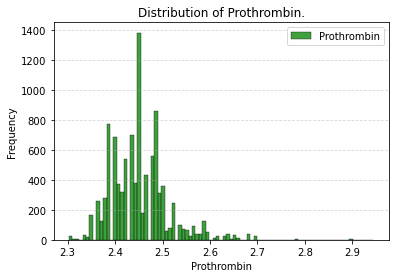

In [424]:
sns.histplot(train_df["Prothrombin"], color="green", label="Prothrombin")
plt.title('Distribution of Prothrombin.')
plt.xlabel('Prothrombin')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

sns.histplot(test_df["Prothrombin"], color="green", label="Prothrombin")
plt.title('Distribution of Prothrombin.')
plt.xlabel('Prothrombin')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [425]:
# Check if there is any remaining missing values.
print(train_df.isnull().sum())
print("___"*20)
print(test_df.isnull().sum())

N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64
____________________________________________________________
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


Now there is no missing values

In [426]:
print(train_df.head(10))
print("____"*20)
print(test_df.head())

     N_Days             Drug       Age Sex  Ascites Hepatomegaly  Spiders  \
0  7.433075          Placebo  3.850148   F        N            Y        Y   
1  7.703910  D-penicillamine  3.988984   F        Y            Y        N   
2  7.453562          Placebo  3.583519   F        N            N        N   
3  7.811568  D-penicillamine  4.043051   F        N            N        Y   
4  6.907755  D-penicillamine  4.304065   M        N            N        N   
5  5.231109  D-penicillamine  4.007333   F        Y            Y        Y   
6  8.381603  D-penicillamine  4.043051   F        N            N        N   
7  7.221105          Unknown  4.060443   F  Unknown      Unknown  Unknown   
8  7.849324  D-penicillamine  3.784190   F        N            Y        N   
9  7.170888          Placebo  4.025352   F        N            Y        N   

  Edema  Bilirubin  Cholesterol   Albumin    Copper  Alk_Phos      SGOT  \
0     N   2.734368     6.244167  1.425515  3.761200  7.689371  5.225747   
1 

##### Exploring Visualization

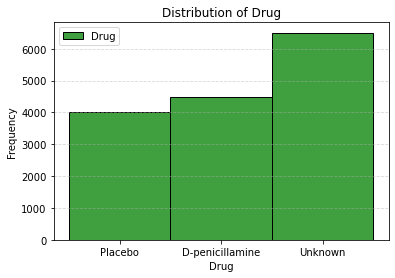

In [427]:
sns.histplot(train_df["Drug"], color="green", label="Drug")
plt.title('Distribution of Drug')
plt.xlabel('Drug')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

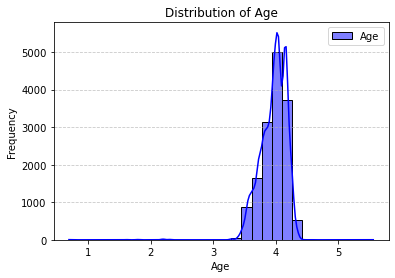

In [428]:
sns.histplot(train_df["Age"], bins=30, kde=True, color="blue", label="Age")
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

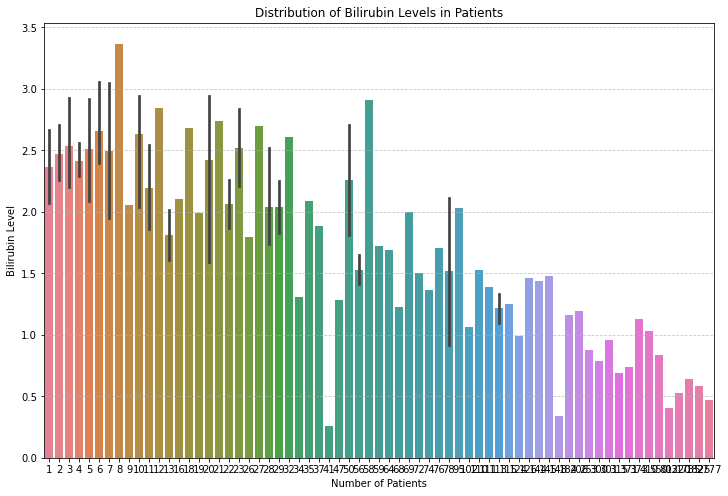

In [429]:
industry_counts = train_df["Bilirubin"].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(y=industry_counts.index, x=industry_counts.values, palette='husl')
plt.title('Distribution of Bilirubin Levels in Patients')
plt.xlabel('Number of Patients')
plt.ylabel('Bilirubin Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

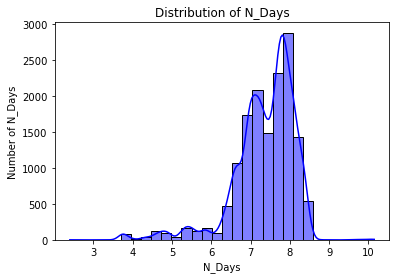

In [430]:
sns.histplot(train_df['N_Days'], bins = 30, kde = True, color = 'blue')
plt.title('Distribution of N_Days')
plt.xlabel('N_Days')
plt.ylabel('Number of N_Days')
plt.show()

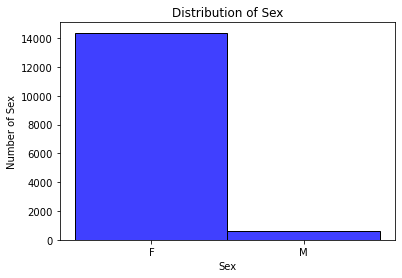

In [431]:
sns.histplot(train_df['Sex'], bins = 30, color = 'blue')
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Sex')
plt.show()

According to the distrbution most of the patient are Female

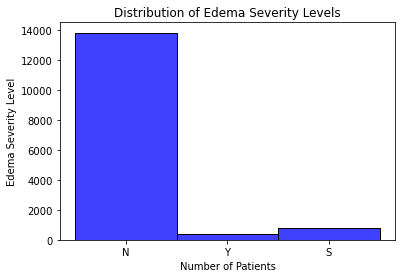

In [432]:

sns.histplot(train_df['Edema'], bins = 30, color = 'blue')
plt.title('Distribution of Edema Severity Levels')
plt.xlabel('Number of Patients')
plt.ylabel('Edema Severity Level')
plt.show()

In [433]:
# Encoding categorical variables
label_encoders = {}
for col in train_categorical_columns:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le

for col in test_categorical_columns:
    le = LabelEncoder()
    test_df[col] = le.fit_transform(test_df[col])
    label_encoders[col] = le
 

In [434]:
# Encode the target variable
target_encoder = LabelEncoder()
train_df['Status'] = target_encoder.fit_transform(train_df['Status'])

In [435]:
# Train-Test Split
X = train_df.drop(columns=['Status'])
y = train_df['Status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [436]:
# Initialize Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
}

In [437]:
# Train & Evaluate Models

model_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_val, y_pred)
    model_results[name] = {"Accuracy": acc, "Classification Report": report, "Confusion Matrix": conf_matrix}

In [106]:
print(model_results)

{'Logistic Regression': {'Accuracy': 0.9217557251908397, 'Classification Report': {'0': {'precision': 0.9217557251908397, 'recall': 1.0, 'f1-score': 0.9592850049652433, 'support': 483}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 39}, 'accuracy': 0.9217557251908397, 'macro avg': {'precision': 0.30725190839694655, 'recall': 0.3333333333333333, 'f1-score': 0.31976166832174774, 'support': 524}, 'weighted avg': {'precision': 0.8496336169220908, 'recall': 0.9217557251908397, 'f1-score': 0.8842264454164361, 'support': 524}}, 'Confusion Matrix': array([[483,   0,   0],
       [  2,   0,   0],
       [ 39,   0,   0]], dtype=int64)}, 'Decision Tree': {'Accuracy': 0.8435114503816794, 'Classification Report': {'0': {'precision': 0.9388646288209607, 'recall': 0.8902691511387164, 'f1-score': 0.9139213602550479, 'support': 483}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, '2': {'p

In [439]:
# Choose Best Model (XGBoost was selected based on performance)
best_model = models["XGBoost"]

# Ensure that the target classes are in the right order
status_classes = target_encoder.classes_

# Get predicted probabilities for the test set using the best model
test_probs = best_model.predict_proba(test_df)

# Create a DataFrame to store the predictions
probabilities_df = pd.DataFrame(test_probs, columns=status_classes)

# Prepare the submission format
submission = pd.DataFrame({
    "id": range(1, len(test_probs) + 1),
    "Status_C": probabilities_df[status_classes[0]],
    "Status_CL": probabilities_df[status_classes[1]],
    "Status_D": probabilities_df[status_classes[2]]
})

# Save the submission to a CSV file
submission.to_csv("submission.csv", index=False)

# Output the first few rows to check the result
print(submission.head())

# Re-import the submission.csv to plot the results
submission_df = pd.read_csv("submission.csv")

   id  Status_C  Status_CL  Status_D
0   1  0.016711   0.395347  0.587942
1   2  0.000413   0.000070  0.999517
2   3  0.991787   0.000804  0.007409
3   4  0.939495   0.006644  0.053860
4   5  0.974270   0.000628  0.025102


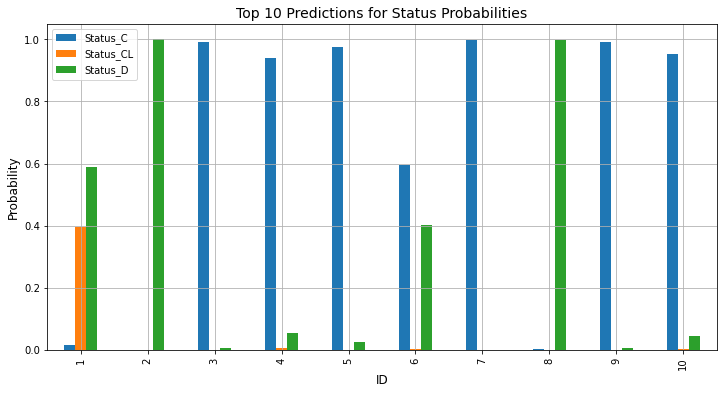

In [441]:
# Create a bar plot to compare the probabilities for each ID
submission_df.set_index('id')[['Status_C', 'Status_CL', 'Status_D']].head(10).plot(kind='bar', figsize=(12, 6))
plt.title("Top 10 Predictions for Status Probabilities", fontsize=14)
plt.xlabel("ID", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.grid(True)
plt.show()
